In [35]:
import pandas as pd
import unicodedata
import string
import re
import numpy as np
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import cross_val_score
plt.style.use('ggplot')


In [3]:
### Creates initial dataframe from .txt files
parties = ['republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'republican', 'republican', 'democrat', 'democrat', 'republican', 'democrat', 'republican', 'democrat']
pres = ['bush', 'carter', 'clinton', 'eisenhower', 'fdroosevelt', 'ford', 'gwbush', 'hoover', 'kennedy', 'lbjohnson', 'nixon', 'obama', 'reagan', 'truman']
war = ['war', 'nw', 'nw', 'nw', 'war', 'nw', 'war', 'nw', 'war', 'war', 'war', 'war', 'nw', 'war']
pres_dict = {}
for i, v in enumerate(pres):
    pres_dict[v]= {}
    pres_dict[v]['party'] = parties[i]

## imports .txt files and puts them into a dictionary
import os
data = []
for i, p in enumerate(pres):
    folder = 'corpus/' + p + '/'
    for filename in os.listdir(folder): 
        indiv = []
        indiv.append(p)
        indiv.append(parties[i])
        indiv.append(war[i])
        path = folder + filename
        if os.path.isfile(path) and filename.endswith(".txt"): 
            with open(path, "r") as file: 
                indiv.append(file.read())
            data.append(indiv)

# for filename in os.listdir('corpus_addendum/'): 
#     indiv = []
#     path = folder + filename
#     print(path)
#     if os.path.isfile(path) and filename.endswith(".txt"): 
#         with open(path, "r") as file:
#             p = filename.split('-')[1][:-4]
#             indiv.append(p)
#             indiv.append(pres_dict[p]['party'])
#             indiv.append(file.read())
#     data.append(indiv)

#converts the dictionary to a dataframe
df = pd.DataFrame (data, columns = ['name', 'party', 'war','speech'])

### splits the speech into title, date, text
def get_text(x):
    idx = x.find('>', x.find('>')+1, 100)
    return x[idx+1:]

df['title'] = df['speech'].apply(lambda x: x.split('"')[1])
df['date'] = df['speech'].apply(lambda x: x.split('"')[3])
df['text'] = df['speech'].apply(get_text)

def is_speech_type(string, speech_type):
    if string.lower().find(speech_type)>=0:
        return True
    else:
        return False

speech_type = ['interview', 'debate', 'inaugural address', 'state of the union', 'press conference']
for i in speech_type:
    df[i] = df.title.apply(lambda x: is_speech_type(x, i))

## Use this function to find parts of the debates that belong to each speaker
def find_between( s, first, last ):
    result = ''
    while True:
        try:
            start = s.index(first) + len(first)
            end = s.index( last, start )
            result += s[start:end] + ' '
            s = s[end:]
        except ValueError:
            return result

In [4]:
df.head()

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [5]:
df.head()

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference
0,bush,republican,war,"<title=""Address at West Point"">\n<date=""Januar...",Address at West Point,"January 5, 1993",\nThank you all very much. Good luck. Please b...,False,False,False,False,False
1,bush,republican,war,"<title=""Address on Somalia"">\n<date=""December ...",Address on Somalia,"December 4, 1992",\nI want to talk to you today about the traged...,False,False,False,False,False
2,bush,republican,war,"<title=""Address on Iraq's Invasion of Kuwait"">...",Address on Iraq's Invasion of Kuwait,"August 8, 1990","\nIn the life of a nation, we're called upon t...",False,False,False,False,False
3,bush,republican,war,"<title=""Address Before a Joint Session of Cong...",Address Before a Joint Session of Congress,"September 11, 1990",\nMr. President and Mr. Speaker and Members of...,False,False,False,False,False
4,bush,republican,war,"<title=""Remarks at Texas A and M University"">\...",Remarks at Texas A and M University,"December 15, 1992",\nThank you all for that welcome back. Thank y...,False,False,False,False,False


In [6]:
idx = [5 ,13, 23, 26, 28, 41,60, 252, 253, 260, 265, 449, 453]
opponent = [['clinton', 'democrat'], ['dukakis', 'democrat'], ['ford', 'republican'], ['ford', 'republican'],
            ['ford', 'republican'], ['reagan', 'republican'], ['dole', 'republican'], ['nixon', 'republican'], ['nixon', 'republican'],
            ['nixon', 'republican'], ['nixon', 'republican'], ['mondale','democrat'], ['mondale','democrat']]
        
delimiters = [['Bush.>', '>', '<Governor Clinton.', '>'], ['BUSH:>', '<', '<DUKAKIS:','>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'], 
              ['MR. CARTER.>', '<', '<THE PRESIDENT.', '>'],['THE PRESIDENT.>', '<', '<GOVERNOR REAGAN.', '>'],
             ['<PRESIDENT CLINTON:>', '<', '<SENATOR DOLE:', '<'],['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'],
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], 
              ['<MR. KENNEDY:>', '<', '<MR. NIXON:', '>'], ['<The President.>', '<', '<Mr. Mondale.', '>'],
              ['<PRESIDENT REAGAN:>', '<', '<MR. MONDALE:', '>']]
opponents = []
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False, False])
opponents = pd.DataFrame(data = opponents, columns = df.columns)
df = pd.concat([df, opponents])

In [7]:
import pprint
# Requests sends and recieves HTTP requests.
import requests

# Beautiful Soup parses HTML documents in python.
from bs4 import BeautifulSoup

url = 'https://www.debates.org/voter-education/debate-transcripts/'
req = requests.get(url)
soup = BeautifulSoup(req.content, 'html.parser')

classes = []
class_num = [i for i in range(100, 141)]
for v in [138, 139, 133, 140, 135, 136, 137, 134, 130, 132, 129, 127, 121, 122, 118, 101]:
    class_num.remove(v)

for i in class_num:
    classes.append("page_item page-item-"+str(i))

debate_names = [['kaine', 'democrat', 'pence', 'republican'], ['obama', 'democrat', 'romney', 'republican'],
                ['obama', 'democrat', 'romney', 'republican'], ['biden', 'democrat', 'ryan', 'republican'],
               ['obama', 'democrat', 'romney', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['biden', 'democrat', 'palin', 'republican'], ['mccain', 'republican', 'obama', 'democrat'],
               ['mccain', 'republican', 'obama', 'democrat'], ['bush', 'republican', 'kerry', 'democrat'],
               ['bush','republican','kerry','democrat'], ['cheney', 'republican', 'edwards', 'democrat'],
               ['bush', 'republican', 'kerry', 'democrat'], ['gore', 'democrat', 'bush', 'republican'],
                ['lieberman', 'democrat', 'cheney', 'republican'], ['gore', 'democrat', 'bush', 'republican'],
                ['gore', 'democrat', 'bush', 'republican'], ['gore', 'democrat', 'kemp', 'republican'],
                ['clinton', 'democrat', 'dole', 'republican'], ['gore', 'democrat', 'quayle', 'republican'],
                ['clinton', 'democrat', 'bush', 'republican'], ['clinton', 'democrat', 'bush', 'republican'],
                ['bush', 'republican', 'dukakis', 'democrat'], ['bentsen', 'democrat', 'quayle', 'republican'],
                ['bush', 'republican','ferraro', 'democrat']]

### Gets text from each speech
links = []
for i in classes:
    x = soup.find_all(class_= i)
    links.append('http://debates.org/'+ str(x).split('"')[3])


results = []
for i, link in enumerate(links):
    req = requests.get(link)
    soup_link = BeautifulSoup(req.content, 'html.parser')
    text = soup_link.get_text()
    text = text.lower()
    for v in [0, 2]:
        text_1 = find_between(text, '\n'+debate_names[i][v]+":", ':')
        results.append([debate_names[i][v], debate_names[i][v+1]] + [0, 0, 0, 0] + [text_1] + [False, True, False, False, False])
for i in [18, 20, 24, 27, 31, 33]:
     results[i][0]=results[i][0].replace("bush", "gwbush")
more_debates = pd.DataFrame(data = results, columns = df.columns)
df = pd.concat([df, more_debates])


## EDA!

Counts of types and presidents

In [22]:
df.count()

name                  549
party                 549
war                   549
speech                549
title                 549
date                  549
text                  549
interview             549
debate                549
inaugural address     549
state of the union    549
press conference      549
text length           549
dtype: int64

In [8]:
print('Speeches by president')
print(df.name.value_counts())
print('')
print('speeches by party')
print(df.party.value_counts())

Speeches by president
lbjohnson      71
reagan         60
obama          54
fdroosevelt    49
kennedy        45
gwbush         45
clinton        43
hoover         29
nixon          27
bush           27
carter         22
truman         19
ford           17
eisenhower      6
gore            5
romney          3
kerry           3
mccain          3
cheney          2
dukakis         2
dole            2
biden           2
quayle          2
mondale         2
pence           1
lieberman       1
ryan            1
bentsen         1
palin           1
kemp            1
kaine           1
edwards         1
ferraro         1
Name: name, dtype: int64

speeches by party
democrat      322
republican    227
Name: party, dtype: int64


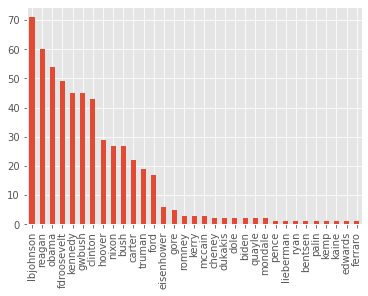

In [36]:
df['name'].value_counts().plot(kind='bar')

LBJ had the most speeches, which lead me to wonder if these were disproportionately press conferences due to the Vietnam War.  It turns out that yes, he had the most press conferences in the corpus, 23 in total.

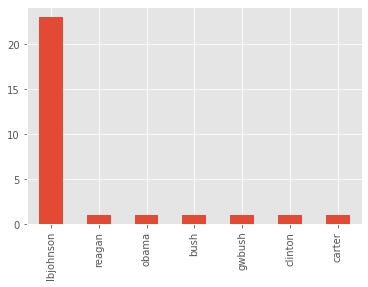

In [37]:
df[df['press conference']== True]['name'].value_counts().plot(kind='bar')

In [9]:
df.groupby('name').sum()

,interview,debate,inaugural address,state of the union,press conference
name,,,,,
bentsen,0.0,1.0,0.0,0.0,0.0
biden,0.0,2.0,0.0,0.0,0.0
bush,0.0,6.0,1.0,3.0,1.0
carter,0.0,4.0,1.0,3.0,1.0
cheney,0.0,2.0,0.0,0.0,0.0
clinton,0.0,5.0,0.0,7.0,1.0
dole,0.0,2.0,0.0,0.0,0.0
dukakis,0.0,2.0,0.0,0.0,0.0
edwards,0.0,1.0,0.0,0.0,0.0


In [14]:
df['text length'] = df.text.apply(lambda x: len(x.split(' ')))

Assuming 150 words spoken per minute, speeches were on average 23 minutes long

In [21]:
df['text length'].mean()/150

23.18415300546448

In [17]:
df.sort_values(by='text length', ascending=False)

,name,party,war,speech,title,date,text,interview,debate,inaugural address,state of the union,press conference,text length
325,lbjohnson,democrat,war,"<title=""State of the Union Address"">\n<date=""J...",State of the Union Address,"January 10, 1967","\nMr. Speaker, Mr. Vice President, distinguish...",False,False,False,True,False,14176
11,obama,democrat,0,0,0,0,"well, thank you very much, jim, and thanks to...",False,True,False,False,False,13229
10,mccain,republican,0,0,0,0,"well, thank you, jim. and thanks to everybody...",False,True,False,False,False,12353
8,bush,republican,war,"<title=""Press Conference with Mikhail Gorbache...",Press Conference with Mikhail Gorbachev,"July 31, 1991","\n\n<President Gorbachev. Good evening, ladies...",False,False,False,False,True,11902
214,hoover,republican,nw,"<title=""First State of the Union Address"">\n<d...",First State of the Union Address,"December 3, 1929",\nTo the Senate and House of Representatives:\...,False,False,False,True,False,10830
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,nixon,republican,war,"<title=""Remarks Announcing an Agreement on Str...",Remarks Announcing an Agreement on Strategic A...,"May 20, 1971","\nGood afternoon, ladies and gentlemen:\nAs yo...",False,False,False,False,False,264
307,lbjohnson,democrat,war,"<title=""Statement on Sending Troops to the Dom...",Statement on Sending Troops to the Dominican R...,"April 28, 1965",\nI have just concluded a meeting with the lea...,False,False,False,False,False,241
202,hoover,republican,nw,"<title=""Message Regarding “Black Thursday”"">\n...",Message Regarding “Black Thursday”,"October 25, 1929",\n<IN REPLY to press questions as to the busin...,False,False,False,False,False,204
120,fdroosevelt,democrat,war,"<title=""Message to Congress Requesting War Dec...",Message to Congress Requesting War Declaration...,"December 11, 1941","<title=""Message to Congress Requesting War Dec...",False,False,False,False,False,144


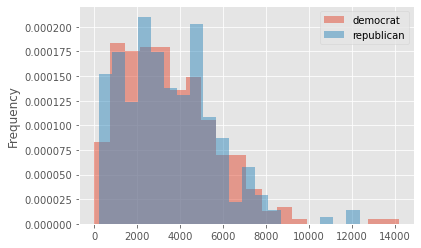

In [41]:
fig, ax = plt.subplots()
df[df['party'] == 'democrat']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'democrat')
df[df['party'] == 'republican']['text length'].plot(kind = 'hist', bins = 20, density = 'true', alpha = .5, label = 'republican')
ax.legend()

In [335]:
df[df['name'] == obama]

NameError: name 'obama' is not defined

In [82]:
#3/7 of presidents are classified as "not war" (Hoover, Eisenhower, Ford, Carter, Reagan, Clinton).  
#These presidents have a disproportionate number of 1 term presidents, so their share of speeches are roughly
#proportional to their time in office
print(df['war'].value_counts())
print(169/486, 3/7)

war    317
nw     169
0       13
Name: war, dtype: int64
0.3477366255144033 0.42857142857142855


In [44]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words=sw, max_features=100)
X = count_vector.fit_transform(df.text)
labels = X.get_feature_names()
BoW = pd.DataFrame(X.toarray(), columns=labels)
BoW

AttributeError: get_feature_names not found

In [83]:
# problem with labels name in this box!!!
count_vector = CountVectorizer(stop_words='english', max_features=50)
X = count_vector.fit_transform(df.text)
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
labels = X.get_feature_names()
y_train = y_train.to_numpy()

## Initial Multinomial Bayes' run
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(f'Accuracy: {clf.score(X_test, y_test)}')
print(f'labels: {labels}')

ValueError: Shape of passed values is (499, 50), indices imply (499, 200)

In [34]:
### adding features up to 200
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200)
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
# %

## takes vectorized tokens, target values, and labels for the 
def MNB(vector_array, y, labels):
    BoW = pd.DataFrame(vector_array.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    return (clf.predict(X_test), f'Accuracy: {clf.score(X_test, y_test)}')

print(MNB(X, df.party, labels))


(array(['republican', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'republican', 'republican', 'democrat', 'republican',
       'democrat', 'republican', 'democrat', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'democrat', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'republican', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'democrat', 'democrat',
       'republican', 'democrat', 'democrat', 'democrat', 'democrat',
       'democrat', 'democrat', 'republican', 'democrat', 'republican',
       'republican', 'republican', 'democrat', 'republican', 'republican',
       'republican', 'democrat', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'republican', 'democrat',
       'republican', 'democrat', 'republican', 'republican', 'republican',
       'republican', 'republican', 'republican', 'republican',
       

In [51]:
### adding features up to 200
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%
count_vector = CountVectorizer(stop_words='english', max_features=200, ngram_range = ((1,4)))
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'democrat' 'republican' 'democrat' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'republican' 'democrat' 'republican' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'democrat' 'democrat' 'republican' '

In [52]:
clf.classes_

array(['democrat', 'republican'], dtype='<U10')

In [53]:
def get_top_features(feature_logs, labels, num_features):
    ## returns the top featurs for dems, republications, as well as the features that are unique to 
    #each party in the top num_features
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique
    
    

## the most important features for each class after the 200 word, 3 n-gram
get_top_features(clf.feature_log_prob_, labels, 50)


(array(['national', 'free', 'hope', 'security', 'come', 'freedom', 'like',
        'need', 'long', 'say', 'right', 'way', 'future', 'going', 'good',
        'believe', 'let', 'help', 'mr', 'men', 'nations', 'united states',
        'great', 'today', 'americans', 'want', 've', 'congress',
        'applause', 'just', 'year', 'work', 'know', 'states', 'make',
        'government', 'peace', 'war', 'nation', 'think', 'united', 'time',
        'country', 'america', 'years', 'american', 'new', 'president',
        'world', 'people'], dtype='<U15'),
 array(['iraq', 'going', 'men', 'think', 'come', 'said', 'good', 'mr',
        'national', 'want', 'future', 'way', 'life', '000', 'free',
        'security', 'say', 'federal', 'economic', 'soviet', 'americans',
        'help', 'let', 'nations', 'today', 'year', 'work', 'just', 'make',
        'freedom', 'know', 'united states', 've', 'war', 'congress',
        'great', 'country', 'nation', 'time', 'years', 'united', 'states',
        'president', 

In [ ]:
print(f'Top words for democrats{np.array(labels)[last_5[:15]]}')
print(f'Top unique words for republicans{np.array(labels)[last_class_1[:15]]}')

In [ ]:
print(labels)

In [ ]:
### adding features up to 200, 3-grams, lemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
# %%

count_vector = CountVectorizer(max_features=200, ngram_range = ((1,4)), tokenizer=WordNetLemmatizer())
X = count_vector.fit_transform(df.text)
labels = count_vector.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

In [54]:
sw = stopwords.words('english')

In [49]:
## lemmatized

from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
sw = stopwords.words('english')
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['democrat' 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'republican' 'democrat' 'democrat' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'republican' 'democrat' 'democrat'
 'republican' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'republican' 'republican' 'republican'
 'republican' 'democrat' 'republican' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'democrat' 'republican' 'republican'
 'democrat' 'democrat' 'democrat' 'republican' 'republican' 'democrat'
 'democrat' 'republican' 'democrat' 'democrat' 'repu

In [43]:
zero, one, zero_uniqe, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero}')
print(f'one unique: {one}')

zero: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'war' 'every'
 'united' 'america' 'make' 'think' 'government' 'mr' 'new' "n't" 'must'
 'time' 'one' 'country' 'state' 'world' 'nation' 'u' 'would' 'president'
 'year' 'american' 'people' "'s" '--']
one: ['soviet' 'need' 'way' 'today' 'want' 'freedom' 'first' 'say' 'let'
 'force' 'well' 'think' 'right' 'every' 'work' 'tax' 'many' '``'
 'congress' 'great' 'life' "'re" 'make' 'united state' 'war' "''" 'know'
 'mr' "'ve" 'peace' 'united' 'country' 'new' "n't" 'time' 'must' 'america'
 'one' 'would' 'state' 'nation' 'president' 'government' 'world' 'year'
 'u' 'american' 'people' '--' "'s"]
zero unique: ['help' 'day' '``' 'believe' 'good' 'job' 'also' 'let' 'great' 'way'
 'need' 'last' 'first' 'today' "''" 'want' 'many' 'united state'
 'applause' "'ve" 'congress' 'peace' 'work' 'know' 'right' 'wa

In [55]:
stop = sw
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## Stop words

In [23]:
sw = stopwords.words('english')

new_sw = ['also', 'day','say', 'le', "'m", 'made', 'mr', 'men', 'candidate', 'instead', 'q', 'part', "'re", "'le", 'get', 'man', "'ve", 'let', 'every', 'may', 'upon', 'shall', 'going','ve','year', '--', '``', "'s", "''", 'way', 'would',"n't", 'must','u','many','one','first','last',"'re'", 'today','', 'ha', 'wa']
for i in new_sw:
    sw.append(i)



In [117]:
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

## This is my main function

In [57]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

token_array = df['text'].apply(doc_to_tokens)

## stores tokens in dictionary
custom_tokens = {}
for i,v in enumerate(token_array.to_numpy()):
    custom_tokens[i] = v

## initializes CV with given tokens and runs MNB prediction
CV = CountVectorizer(
    # so we can pass it strings
    input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
    lowercase=False,
    preprocessor=lambda x: x,
    max_features = 200,
    ngram_range = ((1,3)),
    # use our token dictionary
    tokenizer=lambda key: custom_tokens[key])

X = CV.fit_transform(custom_tokens.keys())
labels = CV.get_feature_names()
# %%
BoW = pd.DataFrame(X.toarray(), columns=labels)
X_train, X_test, y_train, y_test = train_test_split(BoW, df.party)
# %

## Multinomial Bayes' run
import numpy as np
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
MultinomialNB()
print(clf.predict(X_test))
print(clf.score(X_test, y_test))

['republican' 'democrat' 'democrat' 'democrat' 'republican' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'democrat' 'republican' 'democrat' 'democrat' 'republican'
 'democrat' 'republican' 'republican' 'republican' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'democrat' 'democrat'
 'democrat' 'democrat' 'republican' 'republican' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'republican' 'democrat'
 'republican' 'democrat' 'democrat' 'democrat' 'democrat' 'democrat'
 'democrat' 'republican' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'democrat' 'democrat' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'republican' 'democrat' 'republican'
 'republican' 'republican' 'democrat' 'republican' 'democrat' 'democrat'
 'de

In [211]:
from nltk.stem import WordNetLemmatizer
lem = WordNetLemmatizer()
pt = string.punctuation

def doc_to_tokens(doc,sw,ngs=1):
    # lower case all words
    doc = doc.lower()
    # remove accents
    doc = unicodedata.normalize('NFKD', doc).encode('ASCII', 'ignore').decode('utf8')
    # remove odd punctuation
    doc = re.sub(r'[~*.^]*', '', doc)
    # turn document into a list of tokens
    doc = word_tokenize(doc)
    # lemmatize all tokens
    doc = [lem.lemmatize(token) for token in doc]
    # removing stopwords (sw) and punctation (pt)
    doc = [token for token in doc if token not in sw and token not in pt]
    # here we are setting up the bigrams if specified
    ng = list(map(lambda tup: '-'.join(tup), ngrams(doc, ngs)))
    return doc + ng

def run_mnb(sw, text, y, ngrams = 3, max_features = 1500):
    token_array = text.apply(lambda x: doc_to_tokens(x, sw))

    ## stores tokens in dictionary
    custom_tokens = {}
    for i,v in enumerate(token_array.to_numpy()):
        custom_tokens[i] = v

    ## initializes CV with given tokens and runs MNB prediction
    tfidf = TfidfVectorizer(
    # so we can pass it strings
        input='content',
    # turn off preprocessing of strings to avoid corrupting our keys
        lowercase=False,
        preprocessor=lambda x: x,
        max_features = 700,
        ngram_range = ((1,3)),
    # use our token dictionary
        tokenizer=lambda key: custom_tokens[key])

    X = tfidf.fit_transform(custom_tokens.keys())
    labels = tfidf.get_feature_names()
# %%
    BoW = pd.DataFrame(X.toarray(), columns=labels)
    X_train, X_test, y_train, y_test = train_test_split(BoW, y)
# %
    clf = MultinomialNB()
    clf = clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    cvs = np.mean(cross_val_score(clf, X_train, y_train))
    return clf, score, labels, cvs



In [124]:
for i in range(5):
    clf, score, labels, cvs = run_mnb(sw, df['text'], df['party'])
    print(f'Cross val {i}: score {score}, cross val score {cvs}')


Cross val 0: score 0.784, cross val score 0.7379819819819818
Cross val 1: score 0.768, cross val score 0.7165765765765766
Cross val 2: score 0.712, cross val score 0.7352432432432432
Cross val 3: score 0.768, cross val score 0.7246126126126127
Cross val 4: score 0.792, cross val score 0.705945945945946


In [114]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'Dem: {zero}')
print(f'Rep: {one}')
print(f'Dem unique: {zero_unique}')
print(f'Rep unique: {one_unique}')

Dem: ['go' 'bill' 'power' 'national' 'well' 'problem' 'could' 'come' 'family'
 'security' 'q' 'free' 'effort' 'law' 'good' 'future' 'job' 'vietnam'
 'believe' 'need' 'hope' 'help' 'force' 'child' 'freedom' 'life'
 'congress' 'great' 'united state' 'want' 'work' 'make' 'know' 'right'
 'applause' 'government' 'america' 'time' 'united' 'think' 'new' 'state'
 'country' 'peace' 'president' 'war' 'world' 'nation' 'american' 'people']
Rep: ['business' 'citizen' 'want' 'could' 'hope' 'come' 'action' 'good' 'free'
 'law' 'future' 'national' 'tonight' 'system' 'child' 'security' 'vietnam'
 'help' 'need' 'well' 'right' 'economic' 'make' 'program' 'work'
 'united state' 'know' 'force' 'soviet' 'great' 'iraq' 'life' 'congress'
 'war' 'federal' 'freedom' 'united' 'president' 'country' 'tax' 'time'
 'new' 'peace' 'state' 'nation' 'america' 'government' 'world' 'american'
 'people']
Dem unique: ['go', 'bill', 'power', 'problem', 'family', 'q', 'effort', 'job', 'believe', 'applause', 'think']
Rep uniqu

In [130]:
feat = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]
scores = []
for i in feat:
    _, score = run_mnb(max_features = feat)
    scores.append(score)
    

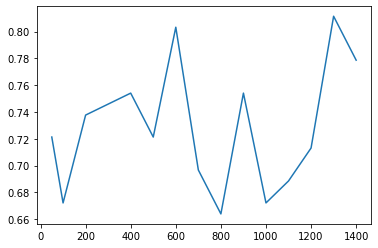

In [134]:
fig, ax = plt.subplots()
ax.plot(feat, scores)

In [129]:
zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(f'zero: {zero}')
print(f'one: {one}')
print(f'zero unique: {zero_unique}')
print(f'one unique: {one_unique}')

zero: ['problem' 'high' 'present' 'different' 'distinguished' 'goal' 'issue'
 'border' 'le' 'peaceful' 'congress' 'get' 'food' 'ensure'
 'fellow american' 'armed' 'economic growth' 'historic' 'even' 'better'
 "'ve" 'destruction' 'freedom' 'press' 'difficult' 'effective' 'candidate'
 'provide' 'giving' 'poor' 'greatest' 'financial' 'man' 'help' 'part'
 'education' 'ahead' 'agency' 'hope' 'information' 'political' 'path'
 'pressure' 'cause' 'job' 'needed' 'purpose' 'hemisphere' 'aggression'
 'instead']
one: ['ahead' 'policy' 'economic growth' 'help' 'different' 'abroad' 'food'
 'peaceful' 'get' 'high' 'present' 'better' 'men' 'official'
 'distinguished' 'historic' 'problem' 'man' 'ensure' 'kind' 'conduct'
 'federal' 'giving' 'financial' 'destruction' 'poor' 'provide' 'pressure'
 'freedom' 'effective' 'difficult' 'candidate' 'decision' 'opinion' "'re"
 'political' 'job' 'cause' 'much' 'path' "'ve" 'hope' 'information'
 'needed' 'hemisphere' 'education' 'agency' 'purpose' 'aggression'
 'in

## Scraping

['page_item page-item-100', 'page_item page-item-102', 'page_item page-item-103', 'page_item page-item-104', 'page_item page-item-105', 'page_item page-item-106', 'page_item page-item-107', 'page_item page-item-108', 'page_item page-item-109', 'page_item page-item-110', 'page_item page-item-111', 'page_item page-item-112', 'page_item page-item-113', 'page_item page-item-115', 'page_item page-item-116', 'page_item page-item-117', 'page_item page-item-119', 'page_item page-item-120', 'page_item page-item-123', 'page_item page-item-124', 'page_item page-item-125', 'page_item page-item-126', 'page_item page-item-128', 'page_item page-item-131']


In [154]:
print(soup.prettify())

<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<html>
 <head>
  <meta content="en-us" http-equiv="Content-Language"/>
  <meta content="text/html;charset=utf-8" http-equiv="Content-Type"/>
  <title>
   CPD: Debate Transcripts
  </title>
  <link href="/wp-content/themes/debates2019/css/reset.css" rel="stylesheet" type="text/css"/>
  <link href="/wp-content/themes/debates2019/css/jc-main.css" media="screen,projection" rel="stylesheet" type="text/css"/>
  <link href="/wp-content/themes/debates2019/css/fonts.css" media="screen,projection" rel="stylesheet" type="text/css"/>
  <!--[if gte IE 5]>
        <link href="/wp-content/themes/debates2019/css/jc-iemain.css" rel="stylesheet" type="text/css" media="screen,projection"  />
        <![endif]-->
  <link href="/wp-content/themes/debates2019/css/styles.css" media="screen" rel="stylesheet" type="text/css"/>
  <style>
   .page-item-44 .children {
    display: none;
}
  </style>
 </head>
 <body>
  <div id="wrapper">
   <div id="h

In [170]:
df.concat(df, )

['pence', 'republican', 0, 0, 0, 0, ' well, first off, thank you, elaine, and thank you to — thank you to norwood university for their wonderful hospitality and the commission on presidential debates. it’s deeply humbling for me to be here, to be surrounded by my — my wonderful family.  well, let me — let me say first and foremost that, senator, you and hillary clinton would know a lot about an insult-driven campaign. it really is remarkable. at a time when literally, in the wake of hillary clinton’s tenure as secretary of state, where she was the architect of the obama administration’s foreign policy, we see entire portions of the world, particularly the wider middle east, literally spinning out of control. i mean, the situation we’re watching hour by hour in syria today is the result of the failed foreign policy and the weak foreign policy that hillary clinton helped lead in this administration and create. the newly emboldened — the aggression of russia, whether it was in ukraine or 

In [ ]:
for i in range(len(idx)):
    text = df.loc[idx[i], 'text']
    df.loc[idx[i],'text'] = find_between(df.loc[idx[i],'text'], delimiters[i][0], delimiters[i][1])
    opponent_text = find_between(text, delimiters[i][2], delimiters[i][3])
    opponents.append(opponent[i] + [0, 0, 0, 0] + [opponent_text] + [False, True, False, False])

In [148]:
text

'\n\n\n\n\ncpd: october 11, 1984 debate transcript\n\n\n\n\n\n\n\n\n\n\n\n\nhome\nabout cpd\ndebate history\nnews\ndebatewatch\nvoter education\ninternational\nmedia\n\n\n\n\n\n\n\n\nin this section\n\n\ndebate videos\ndebate transcripts\n\noctober 19, 2016 debate transcript\noctober 9, 2016 debate transcript\noctober 4, 2016 debate transcript\nseptember 26, 2016 debate transcript\noctober 22, 2012 debate transcript\noctober 16, 2012 debate transcript\noctober 11, 2012 debate transcript\noctober 3, 2012 debate transcript\nseptember 26, 2008 debate transcript\noctober 2, 2008 debate transcript\noctober 7, 2008 debate transcript\noctober 15, 2008 debate transcript\noctober 13, 2004 debate transcript\noctober 8, 2004 debate transcript\noctober 5, 2004 transcript\nseptember 30, 2004 debate transcript\noctober 17, 2000 debate transcript\noctober 11, 2000 debate transcript\noctober 5, 2000 debate transcript\noctober 3, 2000 transcript\noctober 16, 1996 debate transcript\noctober 9, 1996 deba